In [193]:
import itertools, json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import colors

import sys
sys.path.append('..')
from lib import *
from lib.maxent import *
from common import labels


plt.style.use('../peptidome.mplstyle')

from numba import njit

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
def entropy_thermodynamic_integration(model_params,
        integration_intervals=1,
        mcmc_kwargs=dict(), prng=np.random):

    @njit
    def jump(x):
        return local_jump_jit(x, q)

    if params.files == ['f']:
        model = 'independent'
        f = params['f']
        h = np.log(f)
        h -= np.mean(h)
    elif params.files == ['h', 'J']:
        model = 'ncov'
        h = params['h']
        J = params['J']
        @njit
        def energy(x):
            return energy_ncov(x, h, J)
        @njit
        def energy_alpha_gen(x, alpha):
            return energy_ncov(x, h, alpha*J)
        @njit
        def deltaenergy(x):
            return energy_ncov(x, np.zeros_like(h), J)
    elif params.files == ['h', 'J', 'J2']:
        model = 'nskew'
        h = params['h']
        J = params['J']
        J2 = params['J2']
        @njit
        def energy(x):
            return energy_nskew(x, h, J, J2)
        @njit
        def energy_alpha_gen(x, alpha):
            return energy_nskew(x, h, alpha*J, alpha*J2)
        @njit
        def deltaenergy(x):
            return energy_nskew(x, np.zeros_like(h), J, J2)
    elif params.files == ['h', 'J', 'J2', 'hi', 'Jij']:
        model = 'nskewfcov'
        h = params['h']
        hi = params['hi']
        J = params['J']
        J2 = params['J2']
        Jij = params['Jij']
        @njit
        def energy(x):
            return energy_nskewfcov(x, h, J, J2, hi, Jij)
        @njit
        def energy_alpha_gen(x, alpha):
            return energy_nskewfcov(x, h, alpha*J, alpha*J2, hi, alpha*Jij)
        @njit
        def deltaenergy(x):
            return energy_nskewfcov(x, np.zeros_like(h), J, J2, hi, Jij)

    F0 = -k*np.log(np.sum(np.exp(h)))
    if model == 'independent':
        S = -k*np.sum(f*np.log(f))
        return S, S+F0, F0
    
    x0 = prng.randint(q, size=k)
    matrix = mcmcsampler(x0, energy, jump, **mcmc_kwargs)
    energy = np.array([energy(x) for x in matrix])
    energy_mean = np.mean(energy)

    def Fprime(alpha):
        @njit
        def energy_alpha(x):
            return energy_alpha_gen(x, alpha)
        x0 = prng.randint(q, size=k)
        matrix = mcmcsampler(x0, energy_alpha, jump, **mcmc_kwargs)
        return np.mean([deltaenergy(x) for x in matrix])

    xs = np.linspace(0, 1, integration_intervals+1)
    Fprimes = [Fprime(x) for x in xs]
    Fint = scipy.integrate.simps(Fprimes, xs)
    
    F =  F0 + Fint
    S = energy_mean - F
    return S, energy_mean, F

In [30]:
k = 9
q = naminoacids

integration_intervals = 10
mcmc_kwargs = dict(nsteps=1e6, nsample=k, nburnin=1e4)

In [33]:
for model in ['independent', 'ncov', 'nskew', 'nskewfcov']:
    params = np.load('data/Human_{model}_k9_params.npz'.format(model=model))
    S, E, F = entropy_thermodynamic_integration(params,
            integration_intervals=integration_intervals,
            mcmc_kwargs=mcmc_kwargs)
    series = pd.Series(data=[S, E, F], index=['S', 'E', 'F'])
    print(model, series, '%e'%np.exp(series['S']))

independent S    26.037924
E    -1.991594
F   -28.029518
dtype: float64 2.032950e+11
ncov S    25.874759
E    -2.770883
F   -28.645642
dtype: float64 1.726892e+11
nskew S    25.849513
E    -2.772274
F   -28.621787
dtype: float64 1.683840e+11
nskewfcov S    25.827598
E    -2.719647
F   -28.547245
dtype: float64 1.647340e+11


In [2]:
output = True
L = 9
q = naminoacids

proteome = proteome_path('Human')
seed = 1234
prng = np.random.RandomState(seed)

In [3]:
params = np.load('data/Human_%i.npz'%L)
hi = params['hi']
Jij = params['Jij']

In [4]:
datasets = ['test', 'train', 'model']
sample_matrices = {}
for dataset in datasets:
    sample_matrices[dataset] =  load_matrix('data/%s_matrix_L%i.csv.gz' % (dataset, L))

In [5]:
energies = {}
for dataset in datasets:
    energies[dataset] = np.mean([energy_potts(x, hi, Jij) for x in sample_matrices[dataset]])

In [6]:
mcmc_kwargs = dict(nsteps=1e6, nsample=10, nburnin=1e3)

In [7]:
F = Fpotts_thermodynamic_integration(hi, Jij, integration_intervals=3, mcmc_kwargs=mcmc_kwargs)

In [8]:
Suni = np.log(20)*L
'%e'%np.exp(Suni)

'5.120000e+11'

In [9]:
fis = frequencies(sample_matrices['train'], num_symbols=q)

In [10]:
Sind_global = L*scipy.stats.entropy(np.mean(fis, axis=0))
'%e'%np.exp(Sind_global)

'2.032950e+11'

In [11]:
def calc_Sind(fis):
    return np.sum(scipy.stats.entropy(fis.T))

In [12]:
Sind = calc_Sind(fis)
'%e'%np.exp(Sind)

'2.032795e+11'

In [13]:
Smaxent = np.mean(energies['train']) - F
'%e'%np.exp(Smaxent)

'1.710418e+11'

In [14]:
Sind*np.log2(np.exp(1))/L, Smaxent*np.log2(np.exp(1))/L

(4.1738526076016536, 4.146173107830868)

In [15]:
df = pd.read_csv('../kmerentropy/data/entropy.csv')
np.array(df['Human'])/np.arange(1, 6)

array([4.17756346, 4.16934288, 4.16129658, 4.14931991, 4.11369582])

In [16]:
(Suni-Sind)*np.log2(np.exp(1)), (Sind-Smaxent)*np.log2(np.exp(1))

(1.3326793855713739, 0.24911549793707508)

In [17]:
L = 9
mi = pd.read_csv('../pfam/data/mutualinformation_nozf.csv', index_col=0, usecols=(1, 2))
mi = np.asarray(mi.loc[:L-2]).flatten()
np.sum(mi*(L-np.arange(1, L)))

0.33534763650457045

# Global model

In [18]:
sample_matrices['model_global'] =  load_matrix('../globalmaxent/data/model_matrix.csv.gz')
params = np.load('../globalmaxent/data/Human_L%i.npz'%L)
h = params['h']
J = params['J']

In [19]:
Fcov = Fcov_thermodynamic_integration(h, J, L, integration_intervals=3, mcmc_kwargs=mcmc_kwargs)

In [20]:
Scov = np.mean([energy_ncov(x, h, J) for x in sample_matrices['model_global']])-Fcov
'%e'%np.exp(Scov)

'1.794352e+11'

In [194]:
k = 10
models = ['uniform', 'independent', 'ncov', 'nskew', 'nskewfcov']
entropies = np.zeros(len(models))
for i, model in enumerate(models):
    if model == 'uniform':
        S = k*np.log(20)
    else:
        S = np.float(pd.read_csv('data/Human_{model}_k{k}_entropy.csv'.format(model=model, k=k),
                        header=None, index_col=0).loc['S'])
    entropies[i] = S

0.16
0.19
0.23


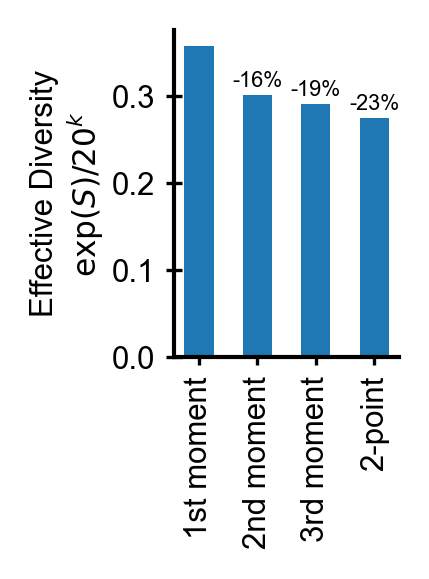

In [195]:
data = np.exp(entropies)
fig, ax = plt.subplots(figsize=(1.5, 2.0))

labels = [labels[model] for model in models[1:]]
width = 0.5  # the width of the bars
x = np.arange(len(labels))  # the label locations
rects = ax.bar(x, data[1:]/data[0], width)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
#ax.axhline(data[1]/data[0], ls='--')

reduction = np.abs((data[2:]-data[1])/data[1])
for rect, toplabel in zip(rects[1:], reduction):
    print('{0:.2f}'.format(toplabel))
    ax.annotate('-{0:.0f}%'.format(100*toplabel),
                xy=(rect.get_x()+width/2, rect.get_height()),
                xytext=(0, 1),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize='xx-small')


ax.set_ylabel('Effective Diversity\n$\exp(S)/20^k$')
fig.tight_layout()
fig.savefig('entropies.png')
fig.savefig(figuredir+'entropies.svg')
fig.savefig('../../paper/images/diversity_reduction.pdf')

In [124]:
np.diff(data)/data[:-1], (data[2:]-data[1])/data[1]

(array([-0.64163104, -0.15889165, -0.03558175, -0.05278879]),
 array([-0.15889165, -0.18881976, -0.23164098]))

In [142]:
ax

<AxesSubplot:ylabel='Effective Diversity\n$\\exp(S)/20^k$'>